In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import xesmf

In [2]:
sodafile = '/work/acr/soda/3.12.2/soda3.12.2_5dy_ocean_reg_1993_01_04.nc'
soda = xarray.open_dataset(sodafile)

hgrid_file = '../../run/INPUT/ocean_hgrid.nc'

# write_soda_boundary_demo.py / boundary.py

In [3]:
hgrid = xarray.open_dataset(hgrid_file)

In [4]:
soda_u = (
    soda[['u', 'v', 'yu_ocean', 'xu_ocean', 'st_ocean']]
    .rename({'yu_ocean': 'lat', 'xu_ocean': 'lon', 'st_ocean': 'z'})
)

In [5]:
coords = xarray.Dataset({
    'lon': hgrid['x'].isel(nyp=0),
    'lat': hgrid['y'].isel(nyp=0),
    'angle': hgrid['angle_dx'].isel(nyp=0)
})

In [6]:
usource = soda_u['u']
vsource = soda_u['v']
method = 'nearest_s2d'
periodic = False

uregrid = xesmf.Regridder(
    usource,
    coords,
    method=method,
    locstream_out=True,
    periodic=periodic,
    filename='regrid_001_u.nc',
    reuse_weights=True
)
vregrid = xesmf.Regridder(
    vsource,
    coords,
    method=method,
    locstream_out=True,
    periodic=periodic,
    filename='regrid_001_v.nc',
    reuse_weights=True
)

Reuse existing file: regrid_001_u.nc
Reuse existing file: regrid_001_v.nc


In [7]:
udest = uregrid(usource)
vdest = vregrid(vsource)

In [8]:
angle = coords['angle'].rename({'nxp': 'locations'})

In [9]:
urot = np.cos(angle) * udest + np.sin(angle) * vdest
vrot = -np.sin(angle) * udest + np.cos(angle) * vdest

In [10]:
ds_uv = xarray.Dataset({
    f'u_segment_001': urot,
    f'v_segment_001': vrot
})

In [11]:
filled = ds_uv.ffill(dim='locations', limit=None)
filled = filled.ffill(dim='z', limit=None).fillna(0)
filled = filled.transpose('time', 'z', 'locations')

In [12]:
filled['z'] = np.arange(len(filled['z']))

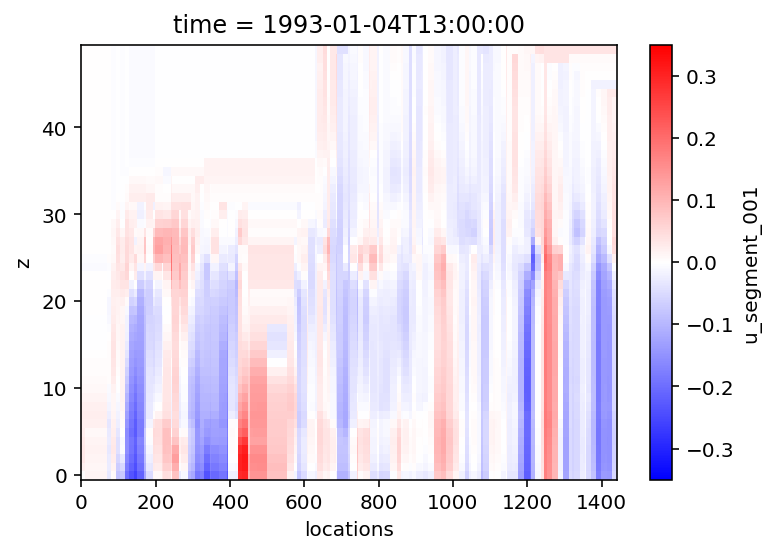

In [13]:
filled['u_segment_001'].isel(time=0).plot(vmin=-.35, vmax=.35, cmap='bwr')

# panArctic_OBC_from_global_MOM6.ipynb

In [14]:
import xarray as xr

In [15]:
def open_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    
    # ! added conversion of angle to degrees
    grid['ds']['angle_dx'] = np.degrees(grid['ds']['angle_dx'])
    
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(1,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(2,nxp+1,2),nyp=slice(2,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(1,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(0,nyp+1,2))
    return grid

regional_grid = open_grid(hgrid_file)

In [16]:
ds_regional=regional_grid['ds']
south = xr.Dataset()
south['lon'] = ds_regional['x'].isel(nyp=0)
south['lat'] = ds_regional['y'].isel(nyp=0)

Note using the data directly from SODA here, rather than the global MOM6 data that needs additional interpolation and rotation beforehand as in the original notebook.

In [17]:
regrid_south_uv = xesmf.Regridder(soda_u[['u', 'v']], south, 'nearest_s2d', 
    locstream_out=True, periodic=False, filename='regrid_south_uv.nc',reuse_weights=True)

Reuse existing file: regrid_south_uv.nc


Regrid, and rename z for compatibility with apply_rotation_transpose().

In [18]:
u_south_r = regrid_south_uv(soda_u['u']).rename({'z': 'z_l'})
v_south_r = regrid_south_uv(soda_u['v']).rename({'z': 'z_l'})

In [19]:
def apply_rotation_transpose(ue,vn,angle_dx,time_slice=slice(0)):
    """Rotate from easterly coordinates to model space"""
    deg_rad=np.pi/180.
    
    if time_slice is not None:
        t=ue.time.isel(time=time_slice)
    else:
        t=ue.time

    if time_slice is not None:
        u=np.cos(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.sin(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
        v=-np.sin(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
    else:
        u=np.cos(angle_dx.data*deg_rad)*ue.data+np.sin(angle_dx.data*deg_rad)*vn.data
        v=-np.sin(angle_dx.data*deg_rad)*ue.data+np.cos(angle_dx.data*deg_rad)*vn.data
    nyp=u.shape[2]
      
    u=xr.DataArray(u,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    v=xr.DataArray(v,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))

    return u,v

u_south,v_south=apply_rotation_transpose(u_south_r,v_south_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[0]),time_slice=None)

In [20]:
u_south['z_l'] = np.arange(len(u_south['z_l']))
da_u=xr.DataArray(u_south.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.))

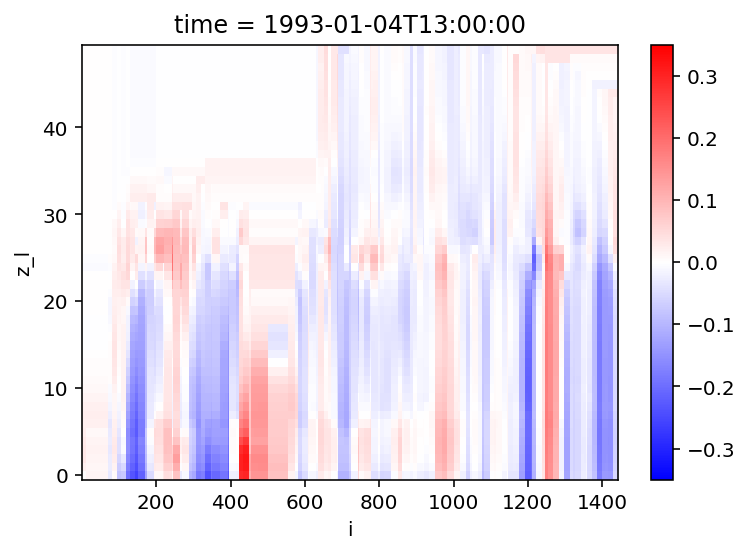

In [21]:
da_u.isel(time=0).plot(vmin=-.35, vmax=.35, cmap='bwr')

# Compare

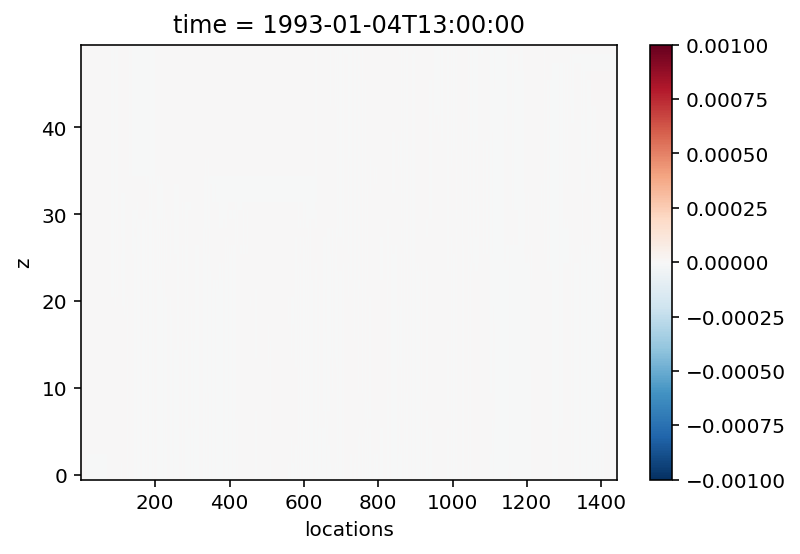

In [22]:
delta = da_u.rename({'z_l': 'z', 'i':'locations'}) - filled['u_segment_001'].isel(time=0)
delta.isel(time=0).plot(vmin=-.001, vmax=.001, cmap='RdBu_r')

In [23]:
np.abs(delta).max()

<xarray.DataArray ()>
array(3.53423051e-08)